# Nội dung chính
1. Lý thuyết mạng RNN
2. Xây dựng mạng RNN bằng Python
3. Xây dựng mạng RNN bằng Tensorflow
4. Xây dựng mạng RNN bằng Keras

Nguồn:
- https://nttuan8.com/bai-13-recurrent-neural-network/
- http://web.stanford.edu/class/cs20si/syllabus.html
- https://dominhhai.github.io/vi/2017/10/implement-rnn-with-python/
- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/recurrent_network.ipynb

# 1. Lý thuyết mạng RNN
Trong các bài trước, chúng ta đã cùng tìm hiểu về mạng neural, nó đem lại những tính chất dường như là vi diệu, tuy nhiên, các mô hình này có vẻ vẫn còn hạn chế. Các input chúng ta đưa vào hoàn toàn độc lập với nhau. Trên thực tế, rất nhiều dữ liệu cũng như sự vật trong cuộc sống có mối tương quan chứ không hề độc lập với nhau. Ví như như 1 video bao gồm nhiều frame nối tiếp nhau, âm nhạc cũng là một dạng chuỗi tuần tự âm thanh, các text xử lý cũng là dạng chuỗi tuần tự... Câu hỏi đặt ra là vậy làm thế nào chúng ta có thể làm cho mô hình của chúng ta có khả năng xử lý chuỗi theo như cách làm của con người.

RNN được tạo ra với mục đích nắm bắt được thông tin dạng chuỗi. Simple Recurrent Network (SRN) được giới thiệu lần đầu bởi Jeff Elman trong paper "Finding structure in time" (Elman, 1990). RNN được gọi là hồi quy (Recurrent) bởi lẽ chúng thực hiện cùng một tác vụ cho tất cả các phần tử của một chuỗi với đầu ra phụ thuộc vào cả các phép tính trước đó. Nói cách khác, RNN có khả năng nhớ các thông tin được tính toán trước đó. Trên lý thuyết, RNN có thể sử dụng được thông tin của một văn bản rất dài, tuy nhiên thực tế thì nó chỉ có thể nhớ được một vài bước trước đó (ta cùng bàn cụ thể vấn đề này sau) mà thôi. Về cơ bản một mạng RNN có dạng như sau:

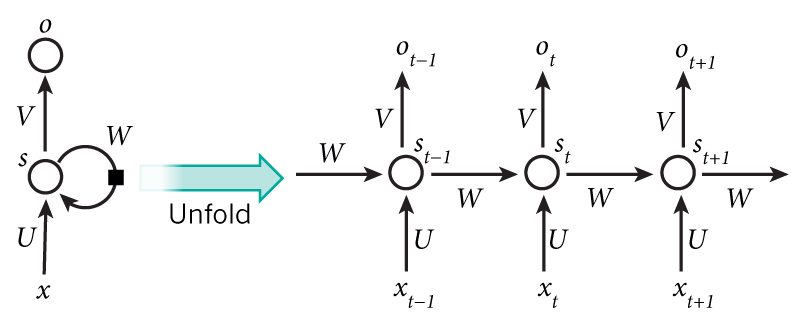

In [1]:
from IPython.display import display, Image
display(Image(filename='./images/rnn.jpg'))

Mô hình trên mô tả phép triển khai nội dung của một RNN. Triển khai ở đây có thể hiểu đơn giản là ta vẽ ra một mạng nơ-ron chuỗi tuần tự. Ví dụ ta có một câu gồm 5 chữ “Đẹp trai lắm gái theo”, thì mạng nơ-ron được triển khai sẽ gồm 5 tầng nơ-ron tương ứng với mỗi chữ một tầng. Lúc đó việc tính toán bên trong RNN được thực hiện như sau:
* $x_t$ là đầu vào bước $t$. Ví dụ, $x_1$ là một vector one-hot tương ứng với từ thứ 2 của câu (trai).
* $s_t$ là trạng thái ẩn tại bước $t$. Nó chính là **bộ nhớ** của mạng, $s_t$ được tính toán dựa trên cả các trạng thái ẩn phía trước và đầu vào tại bước đó: $s_t = f(U x_t + W s_{t-1})$. Hàm $f$ thường là một hàm phi tuyến như tanh hoặc ReLu... Để làm phép toán cho phần tử đầu tiên, ta cần khởi tạo thêm $s_{-1}$, thường giá trị khởi tạo là 0.
* $o_t$ là đầu ra tại bước $t$. Ví dụ ta muốn dự đoán từ tiếp theo có thể xuất hiện trong câu thì $o_t$ chính là một vector xác suất các từ trong danh sách từ vựng của ta: $o_t=g(V s_t)$. $g$ thường là hàm softmax trong bài toán phân loại.

Tóm lại ta có công thức: 
$$s_{t+1} = f(U x_{t+1} + W s_{t})$$
$$o_{t+1} = g(V s_{t+1}) $$
Có thể có thêm các hệ số bias trong công thức trên, trong đó:
* $x_t$ là input vector tại bước t
* $s_t$ là vector lớp ẩn tại bước t
* $o_t$ là output vector tại bước t
* $U, V, W$ là các ma trận tham số ta cần học
* $f, g$ là các hàm activation

Trực quan trên mô hình mạng neural, chúng ta có thể thấy mạng như sau. Tại bước thứ 0: mạng nhận vào input và sinh ra các lớp ẩn:

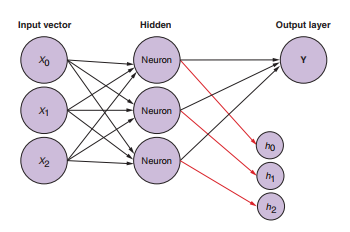

In [2]:
display(Image(filename='./images/rnn-step0.png'))

Tại bước 1, output của lớp 0 sẽ được đưa vào lớp ẩn như là input:

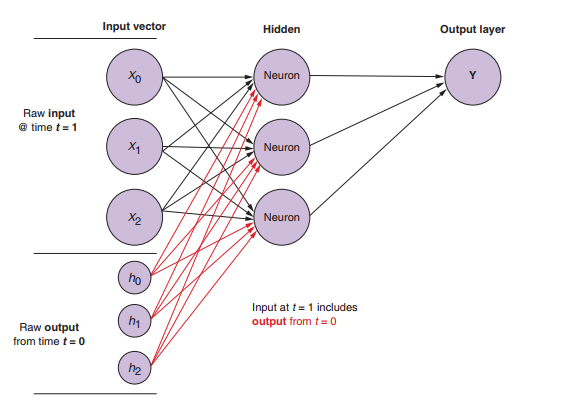

In [3]:
display(Image(filename='./images/rnn-step1.png'))

## 1.1 Loss fuction
Với bài toán phân loại, chúng ta thường sử dụng hàm cross entropy:
$$E(y, \hat{y}) = \sum_t E_t (y_t, \hat{y}_t)$$

## 1.2 Lan truyền ngược

Nhắc lại công thức lan truyền tiến:
$$s_{t+1} = f(U x_{t+1} + W s_{t})$$
$$o_{t+1} = g(V s_{t+1}) $$
Trong đó $o_{t+1} = \hat{y}$ là output cuối cùng của RNN.

Trong RNN, loss của cả mô hình bằng tổng loss của mỗi output. Các tham số chúng ta cần phải tìm là $U, V, W$. Ta cần tính:
$$ \frac{\partial L}{\partial U}, \frac{\partial L}{\partial V}, \frac{\partial L}{\partial W}$$
Tính đạo hàm với $V$ thì khá đơn giản, ta có $o_{t+1}$ là đầu ra cuối cùng của chúng ta. Do đó:
$$ \frac{\partial L}{\partial V} = \frac{\partial L}{\partial o_{t+1}} * \frac{\partial o_{t+1}}{\partial V}$$

Tiếp theo, đạo hàm với $U, W$ thì có:
$$\frac{\partial L}{\partial U} = \frac{\partial L}{\partial o_{t+1}} * \frac{\partial o_{t+1}}{\partial s_{t+1}} * \frac{\partial s_{t+1}}{\partial U} = \frac{\partial L}{\partial o_{t+1}} * \frac{\partial o_{t+1}}{\partial s_{t+1}} * \frac{\partial s_{t+1}}{\partial s_{t}}*...*\frac{\partial s_1}{\partial U}$$
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial o_{t+1}} * \frac{\partial o_{t+1}}{\partial s_{t+1}} * \frac{\partial s_{t+1}}{\partial U} = \frac{\partial L}{\partial o_{t+1}} * \frac{\partial o_{t+1}}{\partial s_{t+1}} * \frac{\partial s_{t+1}}{\partial s_{t}}*...*\frac{\partial s_1}{\partial W}$$

Từ công thức trên, Đầu ra của bài toán chúng ta thường xét dạng xác suất nên giá trị đầu ra từ 0 đến 1. Từ đó, ta thấy có xảy ra hiện tức **vanishing gradient** (tức là nhiều đạo hàm liên tiếp nhỏ hơn 1 nhân với nhau - nếu dãy nhân nhau dài sẽ dấn đến hội tụ về 0 ==> từ đó gây ra hiện tượng "không nhớ"). Còn nếu ngược lại gọi là **exploding gradient** (tích của rất nhiều số lớn hơn 1 sẽ dấn đến vô cùng làm cho bước cập nhật hệ số gradient không còn chính xác). Điều này sẽ được cải tiến trong mô hình LSTM sau này.

# 2. Xây dựng mạng RNN bằng Python

Để hiểu sâu hơn về cách hoạt động của mô hình RNN, trong phần này, chúng ta sẽ cùng xây dựng mô hình RNN sinh ra các câu hội thoại (hay còn gọi là mô hình ngôn ngữ). Tôi sử dụng <a href="./reddit-comments-2015-08.csv">15000 bình luận trên Reddit</a> của <a href="https://console.cloud.google.com/bigquery/?GK=fh-bigquery&page=table&t=2015_08&d=reddit_comments&p=fh-bigquery&redirect_from_classic=true">BigQuery của Google</a>. Và hy vọng các văn bản sinh ra trông có vẻ như người dùng của Reddit. Cũng như các dự án học máy khác, đầu tiên ta cần xử lý dữ liệu thô cho đúng định dạng đầu vào.
## 2.1 Phân rã dữ liệu thô
Ta có dữ liệu văn bản thô, nhưng ta lại muốn dự đoán từng từ một, nên ta cần phải phân ra dữ liệu ta thành từng từ riêng biệt. Đầu tiên ta sẽ phân ra thành từng câu một, sau đó lại phân câu thành từng từ riêng biệt. Ta có thể chia các bình luận bằng dấu cách, nhưng cách đó không giúp ta phân tách được các dấu chấm câu. Ví dụ: “He left!” cần phải chia thành 3 phần: “He”, “left”, ”!”. Để đỡ phải vất vả, ta sẽ sử dụng NLTK với hàm word_tokenize và sent_tokenize để phân tách dữ liệu. Ví dụ:

In [4]:
import nltk
nltk.word_tokenize("Thắng đẹp trai thế nhỉ!")

['Thắng', 'đẹp', 'trai', 'thế', 'nhỉ', '!']

## 2.2 Loại bỏ stop word
Trong hầu hết các văn bản có những từ chỉ xuất hiện 1 hoặc 2 lần, những từ không xuất hiện thường xuyên như thế này ta hoàn toàn có thể loại bỏ. Càng nhiều từ thì mô hình của ta học càng chậm (ta sẽ nói lý do sau), và chúng ta không có nhiều ví dụ sử dụng những từ đó nên không thể nào mà học cách sử dụng chúng sao cho chính xác được. Việc này cũng khá giống với cách con người học. Để hiểu cách sử dụng một từ chuẩn xác, bạn cần phải xem xét nó ở nhiều ngữ cảnh khác nhau.

Ta sẽ giới hạn lượng từ vựng phổ biến của ta bằng biến `vocabulary_size` (ở đây, tôi để là 8000, nhưng bạn cứ thay đổi nó thoải mái). Những từ ít gặp không nằm trong danh sách các từ phổ biến, ta sẽ thay thế nó bằng `UNKNOWN_TOKEN`. Ví dụ, nếu danh sách vựng của ta không có từ `“nonlinearities”` thì câu `“nonlineraties are important in Neural Networks”` sẽ được chuyển hoá thành `“UNKNOWN_TOKEN are important in Neural Networks”`. Ta sẽ coi `UNKNOWN_TOKEN` cũng là 1 phần của danh sách từ vựng và cũng sẽ dự đoán nó như các từ khác. Khi một từ mới được sinh ra, ta có thể thay thế `UNKNOWN_TOKEN` lại bằng cách lấy ngẫu nhiên một từ nào đó không nằm trong danh sách từ vựng của ta, hoặc ta có thể tạo ra một các từ cho tới khi từ được sinh ra nằm trong danh sách từ của ta.
## 2.3 Thêm ký tự đầu, cuối
Ta cũng muốn xem từ nào là từ bắt đầu và từ nào là từ kết thúc của một câu. Để làm được chuyện đó, ta cần phải thêm vào 2 kí tự đặc biệt cho mỗi câu là: `SENTENCE_START` liền trước câu và `SENTENCE_END` liền sau câu. Nó sẽ cho phép ta đặt câu hỏi là: Giờ ta có một từ là `SENTENCE_START`, thì từ tiếp theo của ta sẽ là gì? Từ tiếp theo chính là từ đầu tiên của câu.

## 2.4 Ma trận hoá dữ liệu
Đầu vào của RNN là các vec-tơ chứ không phải là các chuỗi. Nên ta cần chuyển đổi giữa các từ và địa chỉ tương ứng với `index_to_word` và `word_to_index`. Ví dụ, từ `“friendly”` ở vị trí 2001 trong danh sách từ vựng thì địa chỉ của nó sẽ là 2001. Như vậy tập dữ liệu x của sẽ có dạng: `[0, 179, 314, 416]`, trong đó 0 tương ứng với `SENTENCE_START`. Còn các nhãn (dự đoán) y sẽ là `[179, 341, 416, 1]`, trong đó 1 tương ứng với `SENTENCE_END`. Vì mục tiêu của ta là dự đoán các từ tiếp theo, nên y đơn giản là dịch một vị trí so với x, và kết câu là `SENTENCE_END`. Nói cách khác, với dự đoán chuẩn xác cho từ 179 sẽ là 314.

In [9]:
import pandas as pd

vocabulary_size = 8000
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

data = pd.read_csv('reddit-comments-2015-08.csv')

In [10]:
data

,body
0,I joined a new league this year and they have ...
1,"In your scenario, a person could just not run ..."
2,They don't get paid for how much time you spen...
3,"I dunno, back before the August update in an A..."
4,"No, but Toriyama sometimes would draw himself ..."
...,...
14995,I've got such a good feeling about this season...
14996,insider rank (no cute sign cuz that will make ...
14997,See here for why this isn't as clear a compari...
14998,&gt; If you cannot stop the bleeding by apply...


In [13]:
sentences = data['body'].to_list()
 # Append SENTENCE_START and SENTENCE_END
sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]

In [16]:
sentences[:1]

["SENTENCE_START I joined a new league this year and they have different scoring rules than I'm used to. It's a slight PPR league- .2 PPR. Standard besides 1 points for 15 yards receiving, .2 points per completion, 6 points per TD thrown, and some bonuses for rec/rush/pass yardage. My question is, is it wildly clear that QB has the highest potential for points? I put in the rules at a ranking site and noticed that top QBs had 300 points more than the top RB/WR. Would it be dumb not to grab a QB in the first round? SENTENCE_END"]

In [17]:
print("Xử lý %d sentences"%(len(sentences)))

Xử lý 15000 sentences


In [19]:
# tokenize the sentences into words
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [21]:
# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 76325 unique words tokens.


In [22]:
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)

In [25]:
vocab[:5]

[('.', 68328), (',', 52137), ('the', 48270), ('to', 35179), ('a', 30853)]

In [27]:
index_to_word = [x[0] for x in vocab]

In [29]:
index_to_word.append(unknown_token)

In [30]:
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [33]:
print("Using vocabulary size %d." % vocabulary_size)
print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))


Using vocabulary size 8000.
The least frequent word in our vocabulary is 'reliably' and appeared 10 times.


In [34]:
# Replace all words not in our vocabulary with the unknown token
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

In [36]:
print("Example sentence: \n'%s'" % sentences[0])
print("Example sentence after Pre-processing: \n'%s'" % tokenized_sentences[0])

Example sentence: 
'SENTENCE_START I joined a new league this year and they have different scoring rules than I'm used to. It's a slight PPR league- .2 PPR. Standard besides 1 points for 15 yards receiving, .2 points per completion, 6 points per TD thrown, and some bonuses for rec/rush/pass yardage. My question is, is it wildly clear that QB has the highest potential for points? I put in the rules at a ranking site and noticed that top QBs had 300 points more than the top RB/WR. Would it be dumb not to grab a QB in the first round? SENTENCE_END'
Example sentence after Pre-processing: 
'['SENTENCE_START', 'I', 'joined', 'a', 'new', 'league', 'this', 'year', 'and', 'they', 'have', 'different', 'scoring', 'rules', 'than', 'I', "'m", 'used', 'to', '.', 'It', "'s", 'a', 'slight', 'PPR', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'PPR', '.', 'UNKNOWN_TOKEN', 'besides', '1', 'points', 'for', '15', 'yards', 'receiving', ',', 'UNKNOWN_TOKEN', 'points', 'per', 'completion', ',', '6', 'points', 'per', 'TD

In [38]:
import numpy as np
# Create the training data
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

## 2.5 Xây dựng mạng RNN